# Goal: train a neural network model of good recall rate to detect curves with high ranks
$$Recall = \frac{True Positive(TP)}{Actually Positive(TP + FN)}$$

In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
# import recall function from sklearn
from sklearn.metrics import recall_score
from pathlib import Path

In [2]:
# load your data here. The following ensure this will work on Windows as well as Unix
path = Path("..") / "data_files" / "CustomDataset" / "custom_dataset_600000.parquet"
df = utils.load_data(path)
df.drop(columns=['conductor'],inplace=True)

Loaded the dataset with 1001 features and 600000 curves..


In [3]:
# convert rank to binary classification by setting: > cutoff as 1 and <= as 0
# set the cutoff value
threshold = 4

# convert the rank to binary classification
df = utils.convert_rank_to_binary(df, threshold)

Converted the rank column to binary. The value of 1 means the rank is greater than 4, otherwise 0. Rank counts:
    count
0  392856
1  207144


In [4]:
# choose model parameters
hidden_units = [20]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df,'rank')
# check if we have cuda available
device = utils.get_device()
# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)
# print model summary
utils.model_summary(model)

The input dimension is 1000 and the output dimension is 2.
Device: cpu.
The model has 20,062 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=1000, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [5]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 10
lr = 0.001
evaluator = recall_score
optimizer = optim.Adam(model.parameters(), lr=lr)

Save the model from epoch 3 with recall_score 0.7751714444956018 to ..\trained_models\model.pth


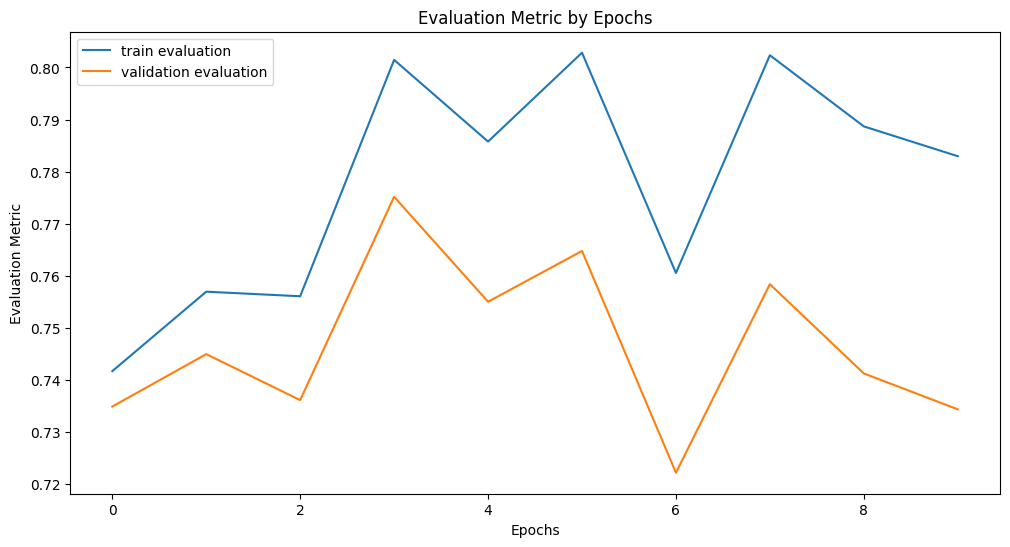

In [6]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df,'rank',device)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs,verbose=False)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [7]:
# test the model
test_res = executor.test(model, test_dataset, evaluator, verbose=True)

Test recall_score: 0.7649183643982084


In [8]:
# # load your data here. The following ensure this will work on Windows as well as Unix
# path = Path("..") / "data_files" / "CustomDataset" / "custom_dataset.parquet"
# df_custom_full = utils.load_data(path)
# df_custom_full.drop(columns=['conductor'],inplace=True)

# # convert the rank to binary classification
# df_custom_full = utils.convert_rank_to_binary(df_custom_full, threshold)

# X = df_custom_full.drop(columns=['rank']).values
# y = df_custom_full['rank'].values

# import torch
# from torch.utils.data import TensorDataset
# X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
# y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# custom_full = TensorDataset(X_tensor, y_tensor)
# test_res = executor.test(model, custom_full, evaluator, verbose=True)